In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

from line import Line


## Finding and correcting for distortion

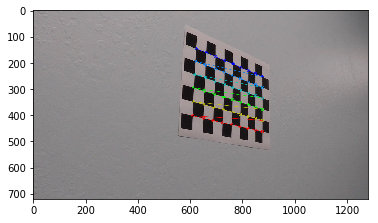

In [2]:
# finding chessboard corners

# prepare object points
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

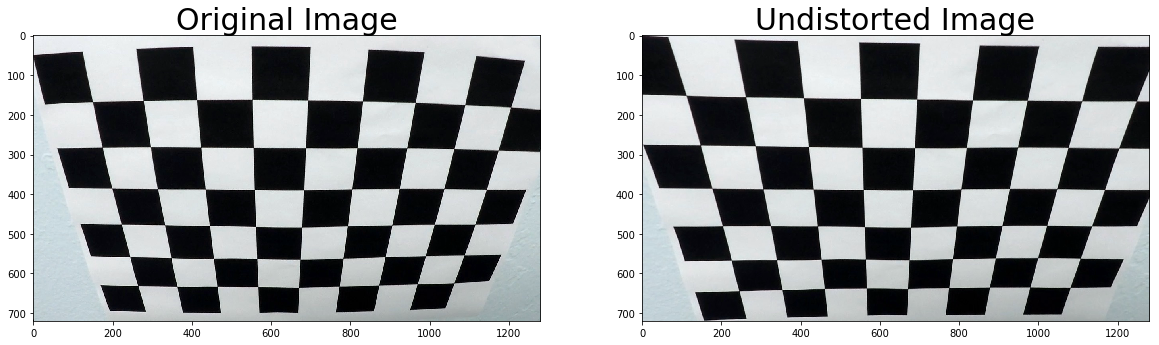

In [3]:
# perform calibration

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist

# test on an image
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

dst, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

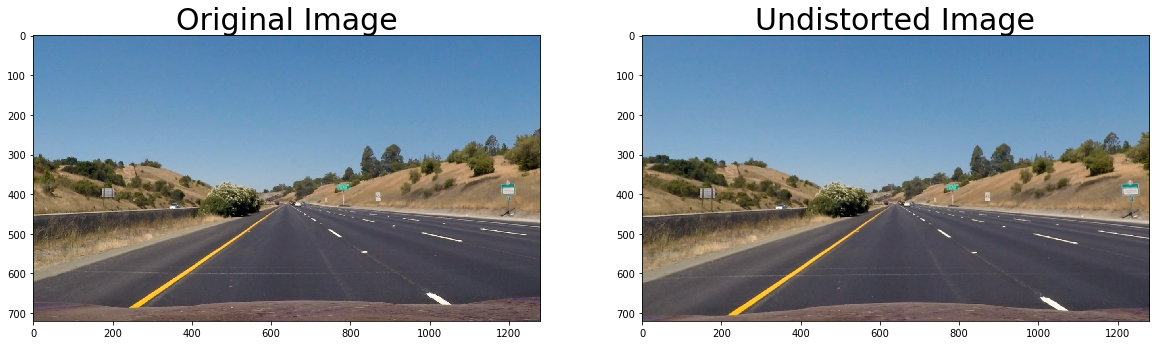

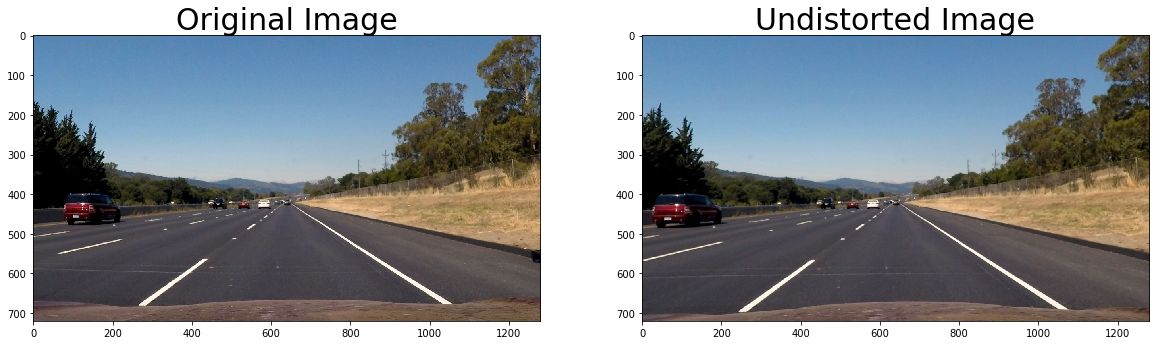

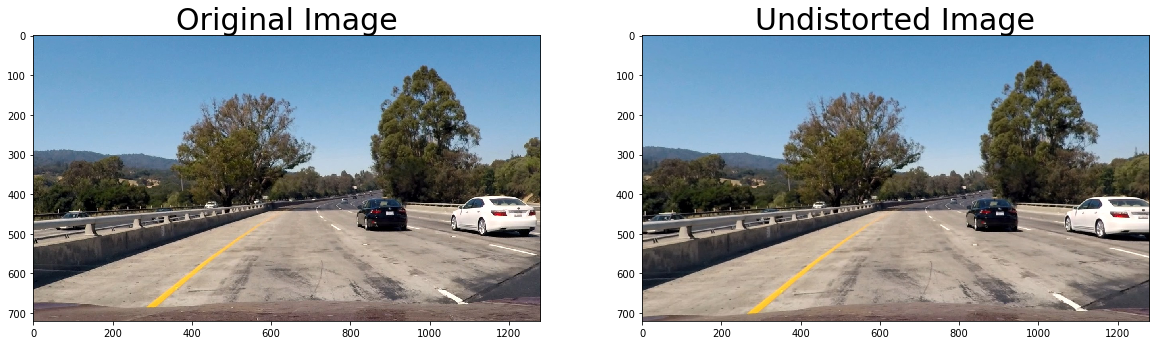

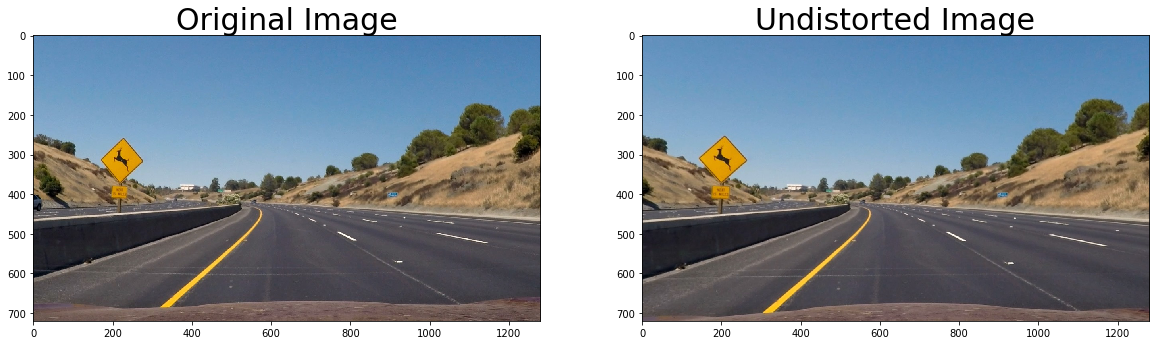

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


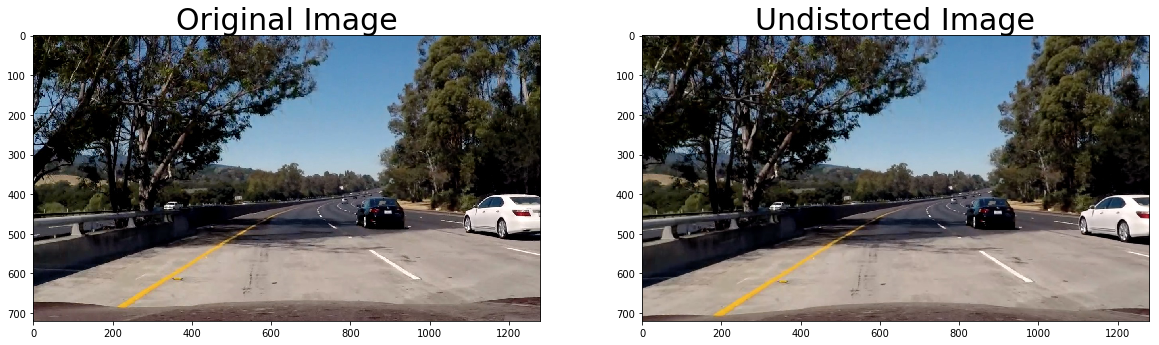

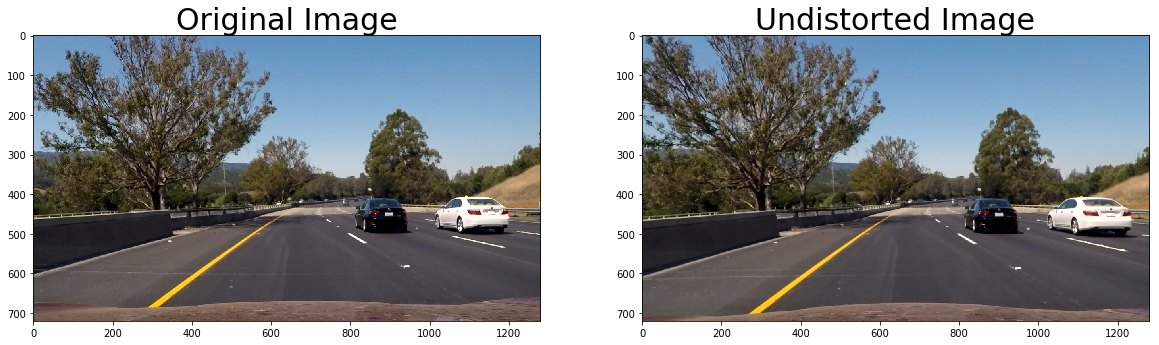

In [4]:
# test undistortions
def test_undistortion(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()

images = glob.glob('./test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    test_undistortion(img)

## Building functions for pipeline and testing

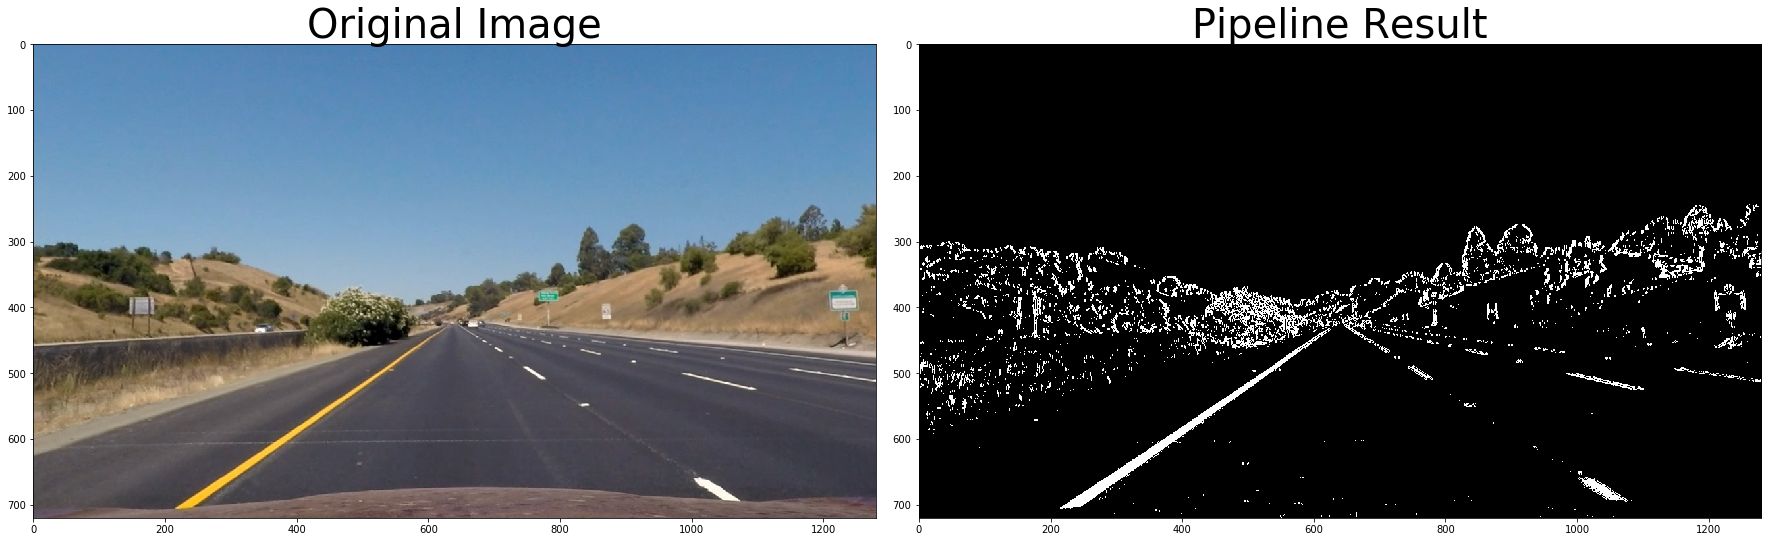

In [22]:
# apply transforms and gradients

def apply_thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    # combined binary
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) | (s_binary == 1))] = 1

    return combined
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary

fname = './test_images/straight_lines1.jpg'
img = mpimg.imread(fname)
img = cv2.undistort(img, mtx, dist, None, mtx)
result = apply_thresholding(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

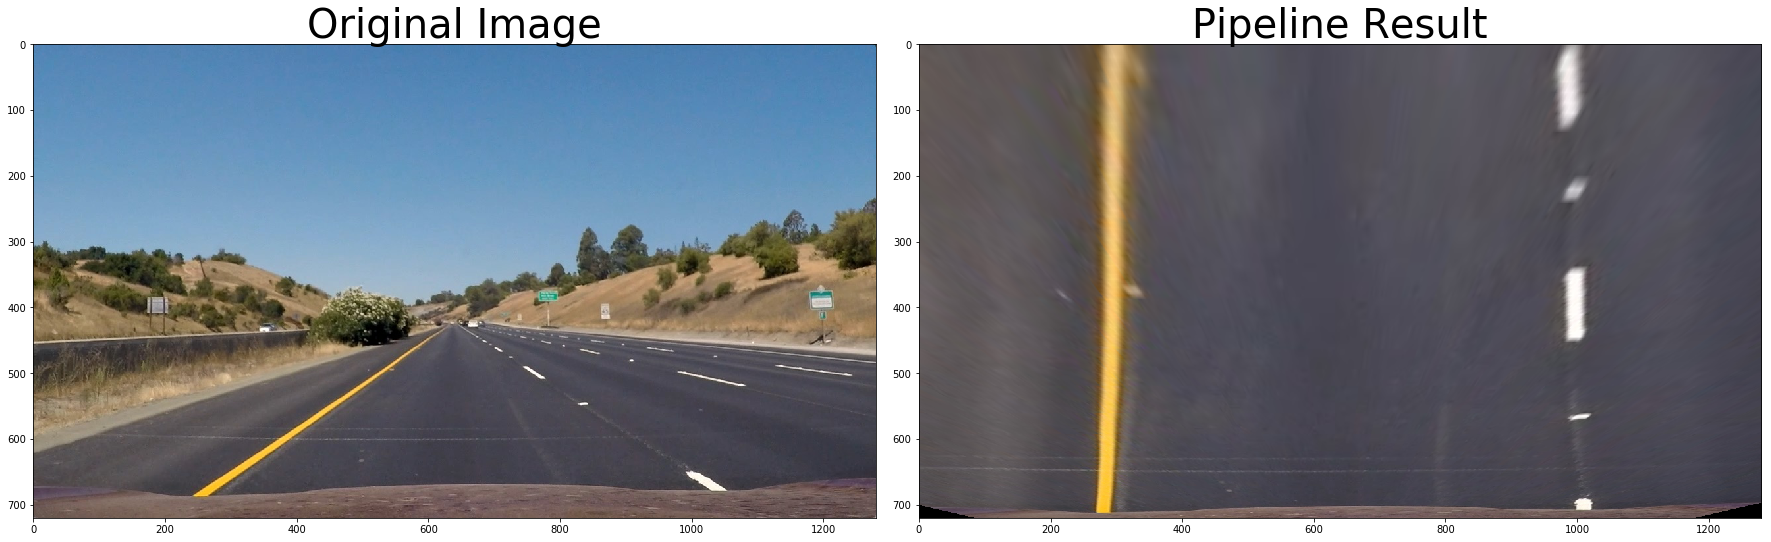

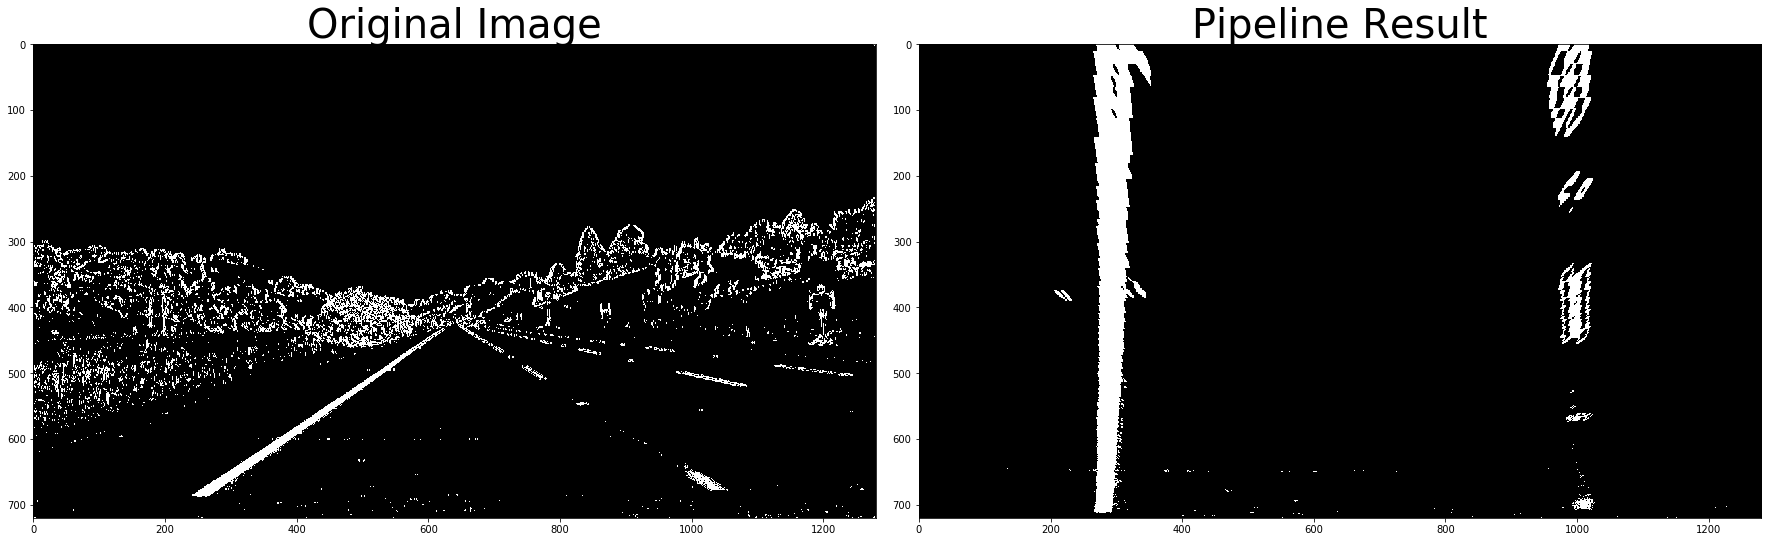

In [32]:
# warp to "birds-eye view"
def warp_image(img, reverse=False):
    #if not reverse:
        #img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = (img.shape[1], img.shape[0])
    # ul - ur - br - bl
    src = np.float32(
        [[(img_size[0] / 2)-58, (img_size[1] / 2)+100],
        [(img_size[0] / 2)+60, (img_size[1] / 2)+100],
        [(img_size[0]) - 230, img_size[1] - 15],
        [250, img_size[1] - 15]])
    
    dst = np.float32(
        [[300, 0],
        [img_size[0]-300, 0],
        [img_size[0]-300, img_size[1]],
        [300, img_size[1]]])
    
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_size))
    
    return warped

# test
fname = './test_images/straight_lines1.jpg'
#img = mpimg.imread(fname)
#img = cv2.undistort(img, mtx, dist, None, mtx)
result = warp_image(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# apply to bw thresholded
bwthresh = apply_thresholding(img)
warped_binary = warp_image(bwthresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bwthresh, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

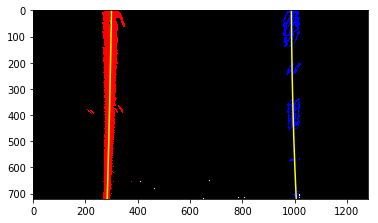

In [29]:
# find lane lines

#histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
#plt.plot(histogram)

def find_lane_lines(warped_binary, left, right):
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    
    # to visualize results
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    
    # find the peak of left and right side
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[:midpoint]) + midpoint
    
    # identify positions of all nonzero pixels
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    if not left.detected or not right.detected:
        # sliding windows
        nwindows = 9
        window_height = np.int(warped_binary.shape[0]/nwindows)

        # current positions to update for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # margin to search and minpix to find
        minpix = 50

        # lists to receive lane pixels
        left.lane_inds = []
        right.lane_inds = []

        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_binary.shape[0] - (window+1)*window_height
            win_y_high = warped_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left.lane_inds.append(good_left_inds)
            right.lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left.lane_inds = np.concatenate(left.lane_inds)
        right.lane_inds = np.concatenate(right.lane_inds)

        # Extract left and right line pixel positions
        left.x_pixelpos = nonzerox[left.lane_inds]
        left.y_pixelpos = nonzeroy[left.lane_inds] 
        right.x_pixelpos = nonzerox[right.lane_inds]
        right.y_pixelpos = nonzeroy[right.lane_inds] 

        # Fit a second order polynomial to each
        left.fit = np.polyfit(left.y_pixelpos, left.x_pixelpos, 2)
        right.fit = np.polyfit(right.y_pixelpos, right.x_pixelpos, 2)
        
    else:
        left.lane_inds = ((nonzerox > (left.fit[0]*(nonzeroy**2) + left.fit[1]*nonzeroy + left.fit[2] - margin)) & (nonzerox < (left.fit[0]*(nonzeroy**2) + left.fit[1]*nonzeroy + left.fit[2] + margin))) 
        right.lane_inds = ((nonzerox > (right.fit[0]*(nonzeroy**2) + right.fit[1]*nonzeroy + right.fit[2] - margin)) & (nonzerox < (right.fit[0]*(nonzeroy**2) + right.fit[1]*nonzeroy + right.fit[2] + margin)))  

        # Extract left and right line pixel positions
        left.x_pixelpos = nonzerox[left.lane_inds]
        left.y_pixelpos = nonzeroy[left.lane_inds] 
        right.x_pixelpos = nonzerox[right.lane_inds]
        right.y_pixelpos = nonzeroy[right.lane_inds] 

        # Fit a second order polynomial to each
        left.fit = np.polyfit(left.y_pixelpos, left.x_pixelpos, 2)
        right.fit = np.polyfit(right.y_pixelpos, right.x_pixelpos, 2)
    
    # -- Drawing functions
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left.fit[0]*ploty**2 + left.fit[1]*ploty + left.fit[2]
    right_fitx = right.fit[0]*ploty**2 + right.fit[1]*ploty + right.fit[2]

    # color in left and right pix
    out_img[nonzeroy[left.lane_inds], nonzerox[left.lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right.lane_inds], nonzerox[right.lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty
    
    
leftl = Line()
rightl = Line()
out_img, left_fitx, right_fitx, ploty = find_lane_lines(warped_binary, leftl, rightl)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

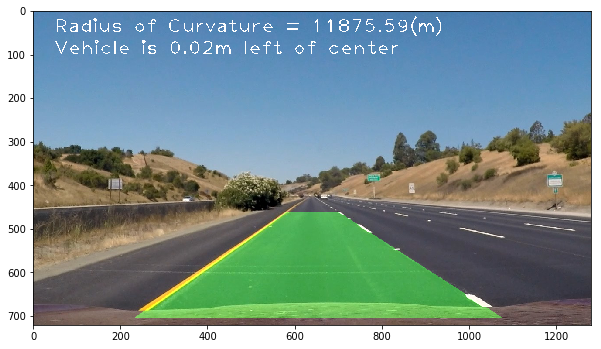

In [48]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# curve detection
def find_curve_and_carlane_pos(warped_binary, left, right):
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left.fit[0]*ploty**2 + left.fit[1]*ploty + left.fit[2]
    right_fitx = right.fit[0]*ploty**2 + right.fit[1]*ploty + right.fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left.radius_of_curvature = ((1 + (2*left.fit[0]*y_eval + left.fit[1])**2)**1.5) / np.absolute(2*left.fit[0])
    #right.radius_of_curvature = ((1 + (2*right.fit[0]*y_eval + right.fit[1])**2)**1.5) / np.absolute(2*right.fit[0])

    # Fit new polynomials to x,y in world space
    #print(ploty.shape, left.x_pixelpos.shape)
    left_fit_cr = np.polyfit(left.y_pixelpos*ym_per_pix, left.x_pixelpos*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right.y_pixelpos*ym_per_pix, right.x_pixelpos*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left.radius_of_curvature, 'm', right.radius_of_curvature, 'm')
    
    #avg curve
    avg_curve = (left.radius_of_curvature + right.radius_of_curvature) / 2
    
    # lane pos
    car_pos = np.mean(np.concatenate([left_fitx, right_fitx], axis=0)) * xm_per_pix
    lane_mid = (warped_binary.shape[1]/2)*xm_per_pix
    car_off_center = lane_mid - car_pos
    
    # build color warp
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    left.detected = True
    right.detected = True
    
    return avg_curve, car_off_center, color_warp
    
avg_curve, car_off_center, color_warp = find_curve_and_carlane_pos(warped_binary, leftl, rightl)

# add text on curve and pos
out = img
if car_off_center < 0.0:
    cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m left of center"
else:
    cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m right of center"

radtext =  "Radius of Curvature = " + "{0:.2f}".format(avg_curve) + "(m)"

cv2.putText(img=out, text=radtext, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
cv2.putText(img=out, text=cartext, org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)

# unwarp to original
unwarped_overlay = warp_image(color_warp, reverse=True)
unwarped_overlay = np.array(unwarped_overlay, np.uint8)


cv2.addWeighted(unwarped_overlay, 0.4, out, 1.0, 0, out)
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

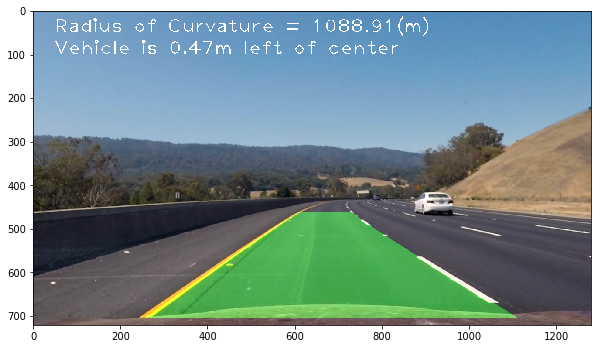

In [55]:
# main pipeline
left = Line()
right = Line()

def main_pipeline(image):
    global left, right
    
    #undistort
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    #warp
    warped = warp_image(undistorted_img)
    
    # threshold and warp image
    thresholded = apply_thresholding(undistorted_img)
    warped_thresholded = warp_image(thresholded)
    
    # detect lines
    out_img, left_fitx, right_fitx, ploty = find_lane_lines(warped_thresholded, left, right)
    
    # find curve
    avg_curve, car_off_center, color_warp = find_curve_and_carlane_pos(warped_thresholded, left, right)
    
    # add text on curve and pos
    out = undistorted_img
    if car_off_center < 0.0:
        cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m left of center"
    else:
        cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m right of center"
        
    radtext =  "Radius of Curvature = " + "{0:.2f}".format(avg_curve) + "(m)"
    
    cv2.putText(img=out, text=radtext, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
    cv2.putText(img=out, text=cartext, org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
    
    # add overlay
    unwarped_overlay = warp_image(color_warp, reverse=True)
    unwarped_overlay = np.array(unwarped_overlay, np.uint8)
    
    
    cv2.addWeighted(unwarped_overlay, 0.4, out, 1.0, 0, out)
    
    return out

fname = './test_images/test3.jpg'
img = mpimg.imread(fname)

out = main_pipeline(img)
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [56]:
# Process Video
from moviepy.editor import VideoFileClip

left = Line()
right = Line()

clip_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:48<00:00,  7.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

Wall time: 2min 49s


In [57]:
# Process challenge Video
from moviepy.editor import VideoFileClip

left = Line()
right = Line()

clip_output = 'challenge_video_output.mp4'
clip = VideoFileClip("challenge_video.mp4")
processed_clip = clip.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:01<00:00,  7.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 2s
